# Machine Learning and Statistics for Physicists

Material for a [UC Irvine](https://uci.edu/) course offered by the [Department of Physics and Astronomy](https://www.physics.uci.edu/).

Content is maintained on [github](github.com/dkirkby/MachineLearningStatistics) and distributed under a [BSD3 license](https://opensource.org/licenses/BSD-3-Clause).

[Table of contents](Contents.ipynb)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [2]:
from sklearn import neighbors

## Markov Chain Monte Carlo

Markov-chain Monte Carlo (MCMC) is an algorithm to generate random samples from an un-normalized probability density.  In other words, you want sample from $P(\vec{z})$ but can only evaluate $f(\vec{z})$ where
$$
P(\vec{z}) = \frac{f(\vec{z})}{\int d\vec{z}\,f(\vec{z})} \; .
$$
Note that $0 \le P(\vec{z}) \le 1$ requires that $f(\vec{z}) \ge 0$ everywhere and that the integral has a non-zero finite value.

### Examples

We will start with some simple motivating examples before diving into the Bayesian applications and the theory of Markov chains.

The function
$$
f(z) = \begin{cases}
\sqrt{1 - z^4} & |z| < 1 \\
0 & |z| \ge 1
\end{cases}
$$
is never negative and has a finite integral:

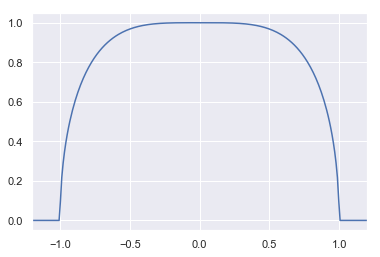

In [3]:
def plotf(zlim=1.2):
    z = np.linspace(-zlim, +zlim, 250)
    plt.plot(z, np.sqrt(np.maximum(0, 1 - z ** 4)))
    plt.xlim(-zlim, +zlim)

plotf()

However, the normalization integral cannot be evaluated analytically (it is related to the [complete elliptic integral of the first kind](https://en.wikipedia.org/wiki/Elliptic_integral#Complete_elliptic_integral_of_the_first_kind)), so this is a good candidate for MCMC sampling using the MLS `MCMC_sample` function (which wraps [emcee](http://dfm.io/emcee/)):

In [4]:
from mls import MCMC_sample

In [5]:
def logf(z):
    return 0.5 * np.log(1 - z ** 4) if np.abs(z) < 1 else -np.inf

gen = np.random.RandomState(seed=123)
samples = MCMC_sample(logf, z=[0], nsamples=20000, random_state=gen)

The notation `z=[0]` identifies `z` as the parameter we want to sample (starting the value 0). The result is a Pandas DataFrame of generated samples:

In [6]:
samples[:5]

,z
0,-0.170898
1,-0.254509
2,-0.299468
3,-0.679219
4,-0.845475


The generated samples are (approximately) drawn from the normalized $P(z)$ corresponding to the $f(z)$ provided:

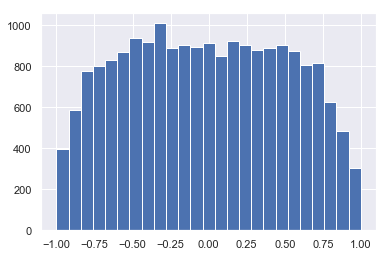

In [7]:
plt.hist(samples['z'], range=(-1,1), bins=25);

What are MCMC samples good for? They allow us to estimate the expectation value of an arbitrary $g(z)$ using [importance sampling](https://en.wikipedia.org/wiki/Importance_sampling):
$$
\langle g(\vec{z})\rangle_P \equiv \int d\vec{z}\, g(\vec{z})\, P(\vec{z})
\simeq \frac{1}{N} \sum_{i=1}^N g(\vec{z}_i) \; ,
$$
where $\vec{z}_1, \vec{z}_2, \ldots$ are the MCMC samples.

For example, to estimate the expectation value of $g(z) = z^2$ (aka the variance) with the samples generated above:

In [8]:
np.mean(samples['z'] ** 2)

0.27477733502973284

Expectation values of more complex functions are equally easy, for example, $g(z) = \sin(\pi z)^2$,

In [9]:
np.mean(np.sin(np.pi * samples['z']) ** 2)

0.5414969519493271

Recall that the reason we are using MCMC is because we do not know the value of the normalization constant:
$$
\int d\vec{z}\,f(\vec{z}) \; .
$$
However, we can use MCMC samples to estimate its value as follows:
 - First, build an empirical estimate of the normalized probability density $P(\vec{z})$ using any density estimation method.
 - Second, compare this density estimate (which is noisy, but normalized by construction) with the original un-normalized $f(\vec{z})$: they should have the same shape and their ratio is the unknown normalization constant.

For example, use KDE to estimate the density of our generated samples:

In [10]:
fit = neighbors.KernelDensity(kernel='gaussian', bandwidth=0.01).fit(samples)

Now take the ratio of the (normalized and noisy) KDE density estimate and the (un-normalized and smooth) $f(z)$ on a grid of $z$ values:

mean P(z)/f(z) = 1.757


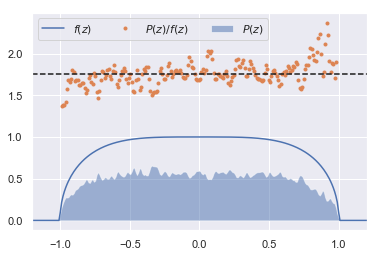

In [11]:
def plotfit(zlim=1.2, Pmin=0.1):
    z = np.linspace(-zlim, +zlim, 250)
    f = np.sqrt(np.maximum(0, 1 - z ** 4))
    P = np.exp(fit.score_samples(z.reshape(-1, 1)))
    plt.plot(z, f, label='$f(z)$')
    plt.fill_between(z, P, alpha=0.5, label='$P(z)$')
    ratio = f / P
    sel = P > Pmin
    plt.plot(z[sel], ratio[sel], '.', label='$P(z)/f(z)$')
    mean_ratio = np.mean(ratio[sel])
    print('mean P(z)/f(z) = {:.3f}'.format(mean_ratio))
    plt.axhline(mean_ratio, ls='--', c='k')
    plt.xlim(-zlim, +zlim)
    plt.legend(loc='upper left', ncol=3)

plotfit()

The estimated $P(z)$ does not look great, but the mean of $f(z) / P(z)$ estimates the normalization constant.  In practice, we restrict this mean to $z$ values where $P(z)$ is above some minimum to avoid regions where the empirical density estimate is poorly determined.

In the example above, the true value of the integral rounds to 1.748 so our numerical accuracy is roughly 1%.

Note that we cannot simply use $g(z) = 1$ in the importance sampled integral above to estimate the normalization constant since it gives exactly one!  The unknown constant is the integral of $f(z)$, not $P(z)$.

Next, we try a multidimensional example:
$$
f(\vec{z}, \vec{z}_0, r) =
\begin{cases}
\exp\left(-|\vec{z} - \vec{z}_0|^2/2\right) & |\vec{z}| < r \\
0 & |\vec{z}| \ge r
\end{cases}
$$
This function describes an un-normalized Gaussian PDF centered at $\vec{z}_0$ and clipped outside $|\vec{z}| < r$. The normalization integral has no analytic solution except in the limits $\vec{z}_0\rightarrow \vec{z}$ or $r\rightarrow\infty$.

To generate MCMC samples in 2D:

In [12]:
def logf(x, y, x0, y0, r):
    z = np.array([x, y])
    z0 = np.array([x0, y0])
    return -0.5 * np.sum((z - z0) ** 2) if np.sum(z ** 2) < r ** 2 else -np.inf

The variables to sample are assigned initial values in square brackets and all other arguments are treated as fixed hyperparameters:

In [13]:
samples = MCMC_sample(logf, x=[0], y=[0], x0=1, y0=-2, r=3, nsamples=10000)

The generated samples now have two columns:

In [14]:
samples[:5]

,x,y
0,1.049259,-2.370577
1,1.049259,-2.370577
2,0.875111,-2.608604
3,0.763691,-2.796067
4,0.763691,-2.796067


A scatter plot shows a 2D Gaussian distribution clipped to a circle and offset from its center, as expected:

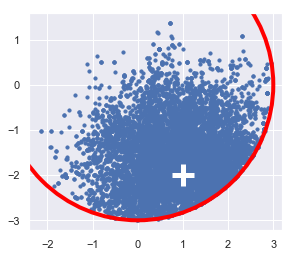

In [15]:
plt.scatter(samples['x'], samples['y'], s=10)
plt.scatter(1, -2, marker='+', s=500, lw=5, c='white')
plt.gca().add_artist(plt.Circle((0, 0), 3, lw=4, ec='red', fc='none'))
plt.gca().set_aspect(1)

With multidimensional samples, we can estimate expectation values of marginal PDFs just as easily as the full joint PDF.  In our 2D example, the marginal PDFs are:
$$
P_X(x) = \int dy\, P(x, y) \quad , \quad P_Y(y) = \int dx\, P(x, y) \; .
$$
For example, the expectation value of $g(x)$ with respect to $P_X$ is:
$$
\langle g\rangle \equiv \int dx\, g(x) P_X(x) = \int dx\, g(x) \int dy\, P(x, y) = \int dx dy\, g(x)\, P(x,y) \; .
$$
In other words, the expectation value with respect to a marginal PDF is equal to the expectation with respect to the full joint PDF.

For example, the expectation value of $g(x) = x$ (aka the mean) with respect to $P_X(x)$ is:

In [16]:
np.mean(samples['x'])

0.8191438988185898

We can also estimate the density of a marginal PDF by simply dropping the columns that are integrated out before plugging into a density estimator.  For example:

In [17]:
fitX = neighbors.KernelDensity(kernel='gaussian', bandwidth=0.1).fit(samples.drop(columns='y'))
fitY = neighbors.KernelDensity(kernel='gaussian', bandwidth=0.1).fit(samples.drop(columns='x'))

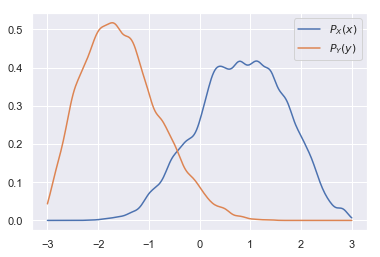

In [18]:
def plotfitXY(r=3):
    xy = np.linspace(-r, +r, 250)
    Px = np.exp(fitX.score_samples(xy.reshape(-1, 1)))
    Py = np.exp(fitY.score_samples(xy.reshape(-1, 1)))
    plt.plot(xy, Px, label='$P_X(x)$')
    plt.plot(xy, Py, label='$P_Y(y)$')
    plt.legend()
    
plotfitXY()

### Bayesian Inference with MCMC

We introduced MCMC above as a general purpose algorithm for sampling any un-normalized PDF, without any reference to Bayesian (or frequentist) statistics. We also never specified whether $\vec{z}$ was something observed (data) or latent (parameters and hyperparameters), because it doesn't matter to MCMC.

However, MCMC is an excellent tool for performing numerical inferences using the generalized Bayes' rule we met earlier:
$$
P(\Theta_M\mid D, M) = \frac{P(D\mid \Theta_M, M)\,P(\Theta_M\mid M)}{P(D\mid M)}
$$
In particular, the normalizing denominator (aka the "evidence"):
$$
P(D\mid M) = \int d\Theta_M' P(D\mid \Theta_M', M)\, P(\Theta_M'\mid M)
$$
is often not practical to calculate, so we can only calculate the un-normalized numerator
$$
P(D\mid \Theta_M, M)\,P(\Theta_M\mid M) \; ,
$$
which combines the *likelihood of the data* and the *prior probability of the model*.

If we treat the observed data $D$ and hyperparameters $M$ as fixed, then the appropriate function to plug into an MCMC is:
$$
\log f(\Theta) = \log P(D\mid \Theta_M, M) + \log P(\Theta_M\mid M) \; .
$$
The machinery described above then enables us to generate samples $\Theta_1, \Theta_2, \ldots$ drawn from the *posterior* distribution, and therefore make interesting statements about probabilities involving model parameters.

The likelihood function depends on the data and model, so could be anything, but we often assume Gaussian errors in the data, which leads to the multivariate Gaussian PDF we met earlier ($d$ is the number of data features):
$$
P(\vec{x}\mid \Theta_M, M) =
\left(2\pi\right)^{-d/2}\,\left| C\right|^{-1/2}\,
\exp\left[  -\frac{1}{2} \left(\vec{x} - \vec{\mu}\right)^T C^{-1} \left(\vec{x} - \vec{\mu}\right) \right]
$$
In the most general case, $\vec{\mu}$ and $C$ are functions of everything: the data $D$, the parameters $\Theta_M$ and the hyperparameters $M$.

When we have $N$ independent observations, $\vec{x}_1, \vec{x}_2, \ldots$, their combined likelihood is the product of each sample's likelihood:
$$
P(\vec{x}_1, \vec{x}_2, \ldots\mid \Theta_M, M) = \prod_{i=1}^N\, P(\vec{x}_i\mid \Theta_M, M)
$$

As an example, consider fitting a straight line $y = m x + b$, with parameters $m$ and $b$, to data with two features $x$ and $y$. The relevant log-likelihood function is:
$$
\log{\cal L}(m, b; D) = -\frac{N}{2}\log(2\pi\sigma_y^2)
-\frac{1}{2\sigma_y^2} \sum_{i=1}^N\, (y_i - m x_i - b)^2 \; ,
$$
where the error in $y$, $\sigma_y$, is a fixed hyperparameter. Note that the first term is the Gaussian PDF normalization factor.

First generate some data on a straight line with measurement errors in $y$ (so our assumed model is correct):

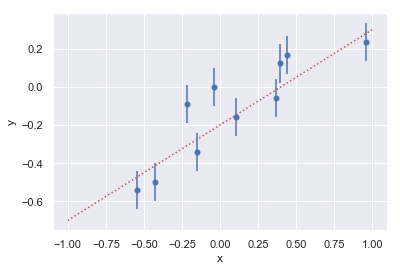

In [19]:
gen = np.random.RandomState(seed=123)
N, m_true, b_true, sigy_true = 10, 0.5, -0.2, 0.1
x_data = gen.uniform(-1, +1, size=N)
y_data = m_true * x_data + b_true + gen.normal(scale=sigy_true, size=N)

plt.errorbar(x_data, y_data, sigy_true, fmt='o', markersize=5)
plt.plot([-1, +1], [-m_true+b_true,+m_true+b_true], 'r:')
plt.xlabel('x'); plt.ylabel('y');

Next, define the log-likelihood function:

In [20]:
def loglike(x, y, m, b, sigy):
    N = len(x)
    norm = 0.5 * N * np.log(2 * np.pi * sigy ** 2)
    return -0.5 * np.sum((y - m * x - b) ** 2) / sigy ** 2 - norm

Finally, generate some MCMC samples of the posterior $P(m, b\mid D, M)$ assuming uniform priors $P(b,m\mid \sigma_y) = 1$:

In [21]:
samples = MCMC_sample(loglike, m=[m_true], b=[b_true],
                      x=x_data, y=y_data, sigy=sigy_true, nsamples=10000, random_state=gen)

/Users/david/anaconda3/envs/MLS/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


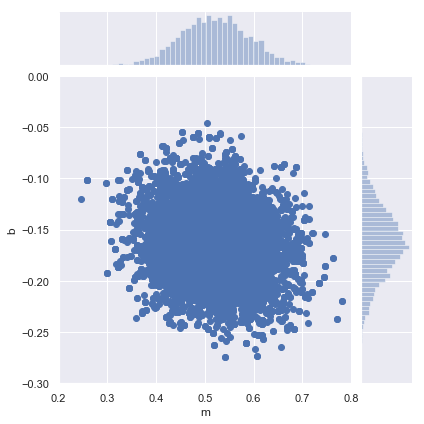

In [22]:
sns.jointplot('m', 'b', samples, xlim=(0.2,0.8), ylim=(-0.3,0.0), stat_func=None);

In [23]:
samples.describe(percentiles=[])

,m,b
count,10000.000000,10000.000000
mean,0.519848,-0.162424
std,0.071418,0.033693
min,0.246512,-0.274527
50%,0.519207,-0.162753
max,0.780647,-0.045919


**EXERCISE:** We always require a starting point to generate MCMC samples. In this example, we used the true parameter values as starting points:
```
m=[m_true], b=[b_true]
```
What happens if you chose different starting points?  Try changing the starting values by $\pm 0.1$ and see how this affects the resulting means and standard deviations for $m$ and $b$.

In [24]:
samples = MCMC_sample(loglike, m=[m_true+0.1], b=[b_true+0.1],
                      x=x_data, y=y_data, sigy=sigy_true, nsamples=10000, random_state=gen)

In [25]:
samples.describe(percentiles=[])

,m,b
count,10000.000000,10000.000000
mean,0.526590,-0.158687
std,0.075981,0.030783
min,0.278667,-0.273902
50%,0.522548,-0.158949
max,0.808847,-0.058641


In [26]:
samples = MCMC_sample(loglike, m=[m_true-0.1], b=[b_true-0.1],
                      x=x_data, y=y_data, sigy=sigy_true, nsamples=10000, random_state=gen)

In [27]:
samples.describe(percentiles=[])

,m,b
count,10000.000000,10000.000000
mean,0.523581,-0.165276
std,0.071686,0.032710
min,0.259379,-0.262730
50%,0.523113,-0.167189
max,0.767536,-0.054175


The changes are small compared with the offsets ($\pm 0.1$) and the standard deviations in each parameter.

In [28]:
# Add your solution here...

The `MCMC_sample` function can apply independent (i.e., factorized) priors on each parameter:
$$
P(\Theta\mid M) = \prod_j P(\theta_j\mid M)
$$
Define the two most commonly used independent priors:

In [29]:
def TopHat(lo, hi):
    """Return un-normalized log(prior) for x in [lo,hi]"""
    return lambda x: 0 if (lo <= x <= hi) else -np.inf

In [30]:
def Gauss(mu, sigma):
    """Return un-normalized log(prior) for x ~ N(mu,sigma)"""
    return lambda x: -0.5 * ((x - mu) / sigma) ** 2

To apply a prior, we replace `z=[value]` with `z=[value,logprior]`.  For example, suppose we believe that $0.4 \le m \le 0.7$:

In [31]:
samples = MCMC_sample(loglike, m=[m_true,TopHat(0.4,0.7)], b=[b_true],
                      x=x_data, y=y_data, sigy=sigy_true, nsamples=10000, random_state=gen)

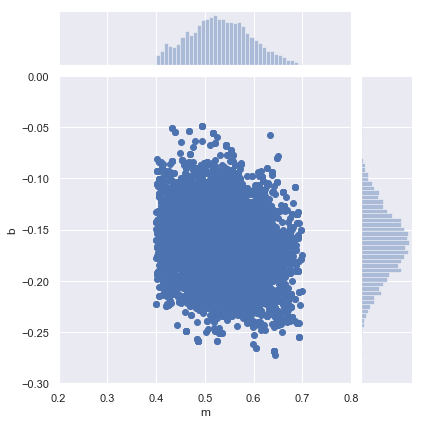

In [32]:
sns.jointplot('m', 'b', samples, xlim=(0.2,0.8), ylim=(-0.3,0.0), stat_func=None);

We can also add a prior on $b$.  For example, suppose a previous measurement found $b = -0.20 \pm 0.02$ (in which case, the new data is not adding much information about $b$):

In [33]:
samples = MCMC_sample(loglike, m=[m_true,TopHat(0.4,0.7)], b=[b_true,Gauss(-0.20,0.02)],
                      x=x_data, y=y_data, sigy=sigy_true, nsamples=10000, random_state=gen)

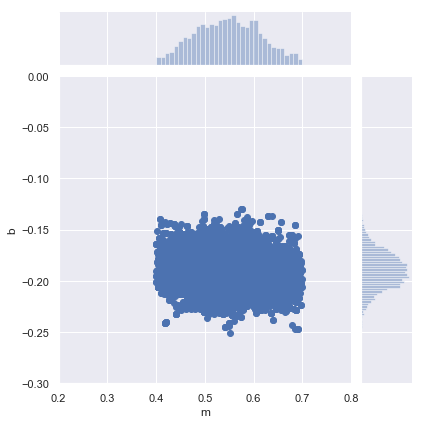

In [34]:
sns.jointplot('m', 'b', samples, xlim=(0.2,0.8), ylim=(-0.3,0.0), stat_func=None);

**EXERCISE:** Suppose we know that all $y_i$ values have the same error $\sigma_y$ but we do not know its value.
 - Generate samples of $(m, b, \sigma_y)$ using `m=[m_true], b=[b_true], sigy=[sigy_true]`.
 - Look at the samples with an `sns.pairplot`.
 - Which panel shows the marginalized posterior $P(\sigma_y\mid D)$? Do you understand its peculiar shape?
 - Add a prior on $\sigma_y$ to fix this peculiar shape.

In [35]:
samples = MCMC_sample(loglike, m=[m_true], b=[b_true], sigy=[sigy_true],
                      x=x_data, y=y_data, nsamples=10000, random_state=gen)

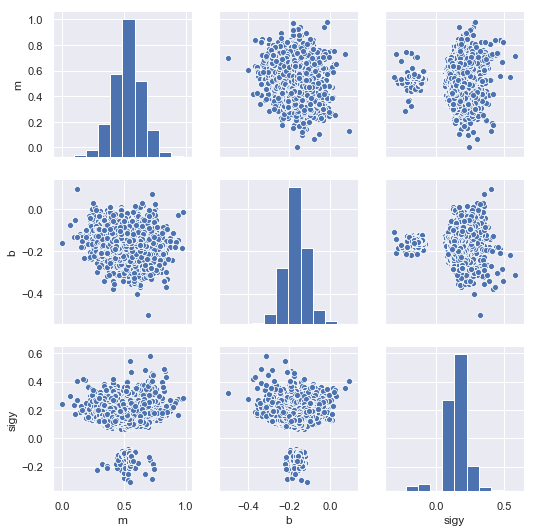

In [36]:
sns.pairplot(samples);

In [37]:
samples = MCMC_sample(loglike, m=[m_true], b=[b_true], sigy=[sigy_true, TopHat(0.01,1)],
                      x=x_data, y=y_data, nsamples=10000, random_state=gen)

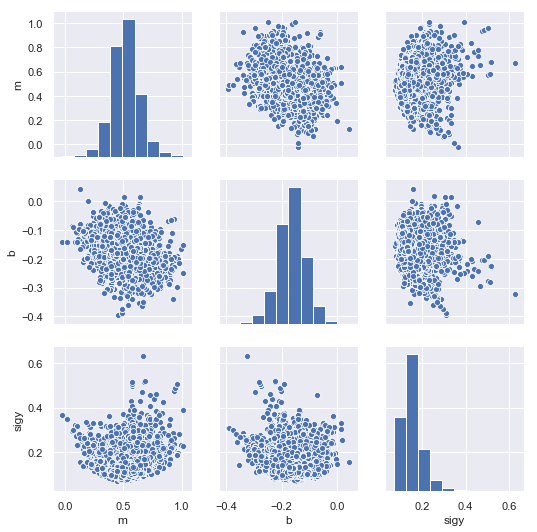

In [38]:
sns.pairplot(samples);

In [39]:
# Add your solution here...

For a more in-depth case study of the many subtleties in fitting a straight line, read this 55-page [article by Hogg, Bovy and Lang](https://arxiv.org/abs/1008.4686).